In [ ]:
!nvidia-smi

Sat Apr 17 13:34:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as T

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from torchsummary import summary
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, classification_report

# Вспомогательные функции

Набор функций, которым мы теперь постоянно будем пользоваться для обучения и тестирования сетей - они не зависят от архитектуры сети

In [ ]:
def validate(model, val_loader, criterion, device):
    model = model.to(device)
    scores = []
    ground_truth = []
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Evaluation', leave=False):
            logits = model(images.to(device))
            scores.append(logits.cpu())
            ground_truth.append(labels)
    scores = torch.cat(scores)
    ground_truth = torch.cat(ground_truth)
    predictions = torch.argmax(scores, dim=1)
    loss = criterion(scores, ground_truth).item()
    accuracy = accuracy_score(ground_truth.numpy(), predictions.numpy())
    return loss, accuracy

In [ ]:
def train(model, train_loader, val_loader, criterion, optimizer, epochs, device):
    history = []
    model = model.to(device)
    with tqdm(desc='Epoch', total=epochs) as epoch_pbar:
        for _ in range(epochs):
            running_loss = 0
            running_corrects = 0
            running_data = 0
            model.train()
            with tqdm(desc='Batch', total=len(train_loader), leave=False) as batch_pbar:
                for batch_count, (images, labels) in enumerate(train_loader, 1):
                    images = images.to(device)
                    labels = labels.to(device)
                    # optimization part
                    optimizer.zero_grad()
                    logits = model(images)
                    loss = criterion(logits, labels)
                    loss.backward()
                    optimizer.step()
                    # calculate metrics
                    running_loss += loss.item()
                    predicts = torch.argmax(logits, dim=1)
                    running_data += images.size(0)
                    running_corrects += (predicts == labels).sum().item()
                    # save metrics history
                    history.append({'train_loss': loss.item(), 'train_acc': running_corrects / running_data})
                    # update progress bar
                    batch_pbar.set_postfix(loss=running_loss / batch_count, acc=running_corrects / running_data)
                    batch_pbar.update()
            model.eval()
            val_loss, val_acc = validate(model, val_loader, criterion, device)
            history[-1]['val_loss'] = val_loss
            history[-1]['val_acc'] = val_acc
            epoch_pbar.set_postfix(
                train_loss=running_loss / len(train_loader),
                val_loss=val_loss,
                train_acc=history[-1]['train_acc'],
                val_acc=val_acc,
            )
            epoch_pbar.update()
    return pd.DataFrame(history)

In [ ]:
def predict(model, loader, device):
    model = model.to(device)
    predictions = []
    with torch.no_grad():
        for images, _ in tqdm(loader, desc='Predict'):
            logits = model(images.to(device))
            prediction.append(torch.argmax(logits, dim=1).cpu().numpy())
    return np.concatenate(predictions)

In [ ]:
# функция принимает на вход список вида [(name_1, history_1), (name_2, history_2), ...]
def plot_experiments(experiments):
    fig, axes = plt.subplots(2, 2, figsize=(25, 13))
    axes = [ax for ax_row in axes for ax in ax_row]
    for name, history in experiments:
        for metric, ax in zip(history.columns, axes):
            marker = 'o' if metric.startswith('val_') else None
            history[metric].dropna().plot(ax=ax, label=name, marker=marker)
    for metric, ax in zip(history.columns, axes):
        ax.set_title(f'{metric} history')
        ax.set_xlabel('Iteration (batch)')
        ax.legend()
    plt.show()

# CIFAR-10

In [ ]:
# превращаем картинки в тензоры и нормализуем
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2435, 0.2616)),
])
# загрузим датасет (обучающую и тестовую часть)
trainset = CIFAR10(root='.', train=True, download=True, transform=transform)
testset = CIFAR10(root='.', train=False, download=True, transform=transform)


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


In [ ]:
train_loader = DataLoader(trainset, batch_size=1024, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(testset, batch_size=1024, shuffle=False, num_workers=2, pin_memory=True)

device = torch.device('cuda')
criterion = nn.CrossEntropyLoss()

In [ ]:
IN_CHANNELS, H, W = 3, 32, 32
N_CLASSES = 10

In [ ]:
# история экспериментов
experiments = {}

# Сложности полносвязных сетей

In [ ]:
# зафиксированные параметры обучения
INPUT_DIM = IN_CHANNELS * H * W
HIDDEN_DIM = 64
EPOCHS = 15

In [ ]:
# функция создает полносвязную сеть с нужным количеством слоев > 1
def make_mlp(input_dim, hidden_dim, out_dim, n_layers, activation):
    return nn.Sequential(
        nn.Flatten(),
        nn.Linear(input_dim, hidden_dim),
        activation(),
        *(nn.Sequential(nn.Linear(hidden_dim, hidden_dim), activation()) for _ in range(n_layers - 2)),
        nn.Linear(hidden_dim, out_dim), 
    )

### Один слой

In [ ]:
model = nn.Sequential(nn.Flatten(), nn.Linear(INPUT_DIM, N_CLASSES))
print(summary(model, input_size=(INPUT_DIM,), device='cpu'))
optimizer = torch.optim.Adam(model.parameters())
experiments['1-layer'] = train(model, train_loader, test_loader, criterion, optimizer, epochs=EPOCHS, device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 3072]               0
            Linear-2                   [-1, 10]          30,730
Total params: 30,730
Trainable params: 30,730
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 0.12
Estimated Total Size (MB): 0.15
----------------------------------------------------------------
None


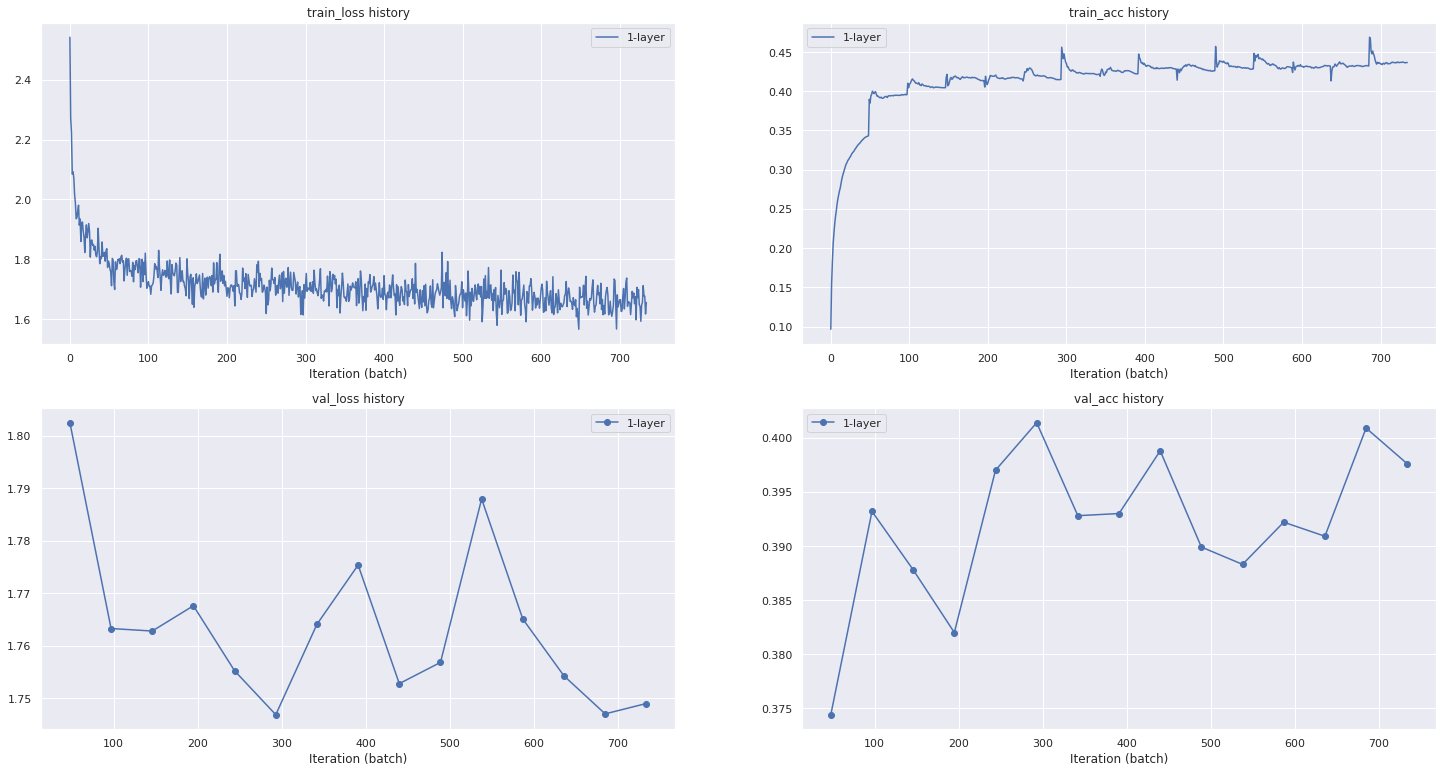

In [ ]:
plot_experiments(experiments.items())

Теперь посмотрим как ведут себя разные функции активации при увеличении глубины сети:

## Сигмоида

### 3 слоя

In [ ]:
n_layers = 3
model = make_mlp(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, out_dim=N_CLASSES, n_layers=n_layers, activation=nn.Sigmoid)
print(summary(model, input_size=(INPUT_DIM,), device='cpu'))
optimizer = torch.optim.Adam(model.parameters())
experiments[f'sigmoid:{n_layers}-layers'] = train(model, train_loader, test_loader, criterion, optimizer, epochs=EPOCHS, device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 3072]               0
            Linear-2                   [-1, 64]         196,672
           Sigmoid-3                   [-1, 64]               0
            Linear-4                   [-1, 64]           4,160
           Sigmoid-5                   [-1, 64]               0
            Linear-6                   [-1, 10]             650
Total params: 201,482
Trainable params: 201,482
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.03
Params size (MB): 0.77
Estimated Total Size (MB): 0.81
----------------------------------------------------------------
None


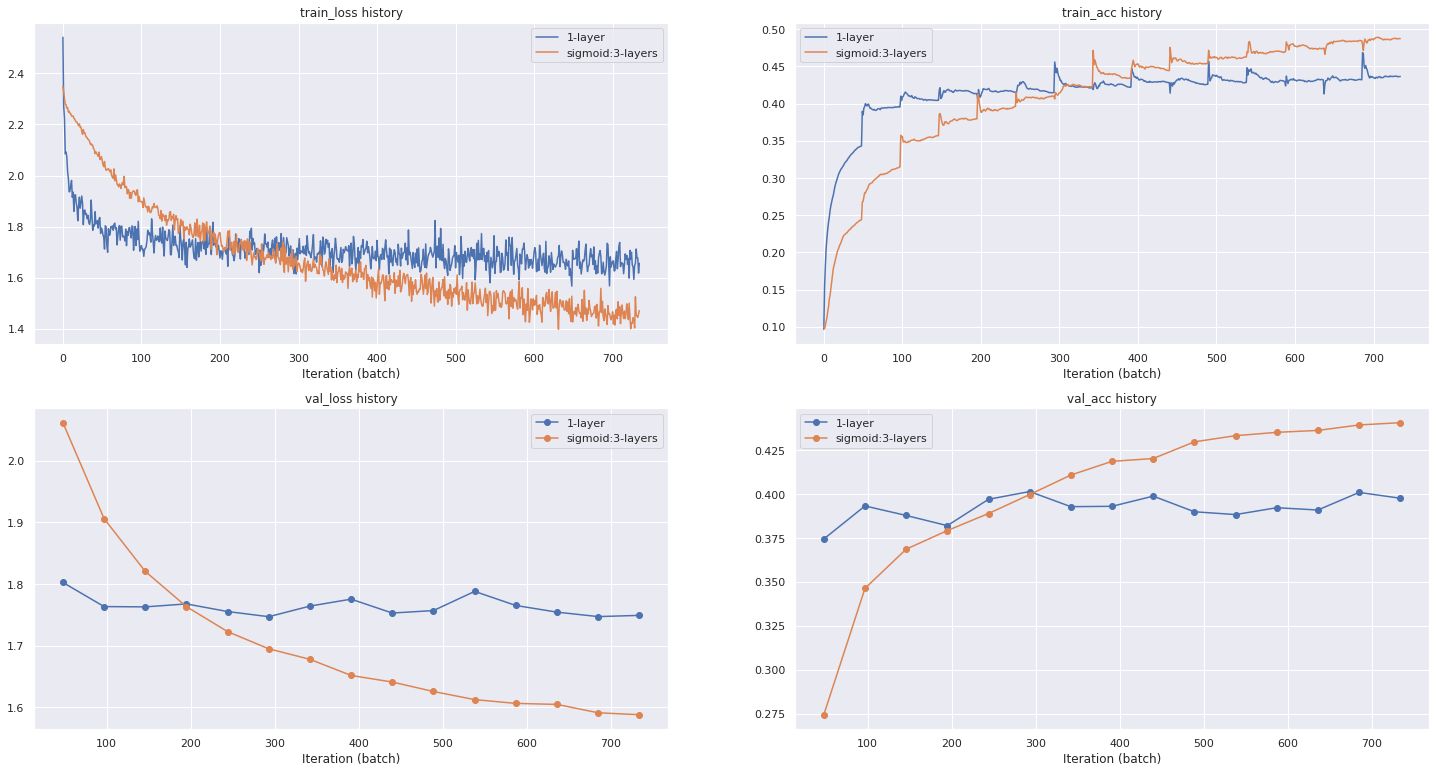

In [ ]:
plot_experiments(experiments.items())

### 5 слоев

In [ ]:
n_layers = 5
model = make_mlp(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, out_dim=N_CLASSES, n_layers=n_layers, activation=nn.Sigmoid)
print(summary(model, input_size=(INPUT_DIM,), device='cpu'))
optimizer = torch.optim.Adam(model.parameters())
experiments[f'sigmoid:{n_layers}-layers'] = train(model, train_loader, test_loader, criterion, optimizer, epochs=EPOCHS, device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 3072]               0
            Linear-2                   [-1, 64]         196,672
           Sigmoid-3                   [-1, 64]               0
            Linear-4                   [-1, 64]           4,160
           Sigmoid-5                   [-1, 64]               0
            Linear-6                   [-1, 64]           4,160
           Sigmoid-7                   [-1, 64]               0
            Linear-8                   [-1, 64]           4,160
           Sigmoid-9                   [-1, 64]               0
           Linear-10                   [-1, 10]             650
Total params: 209,802
Trainable params: 209,802
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.03
Params size (MB): 0.80
Estimated T

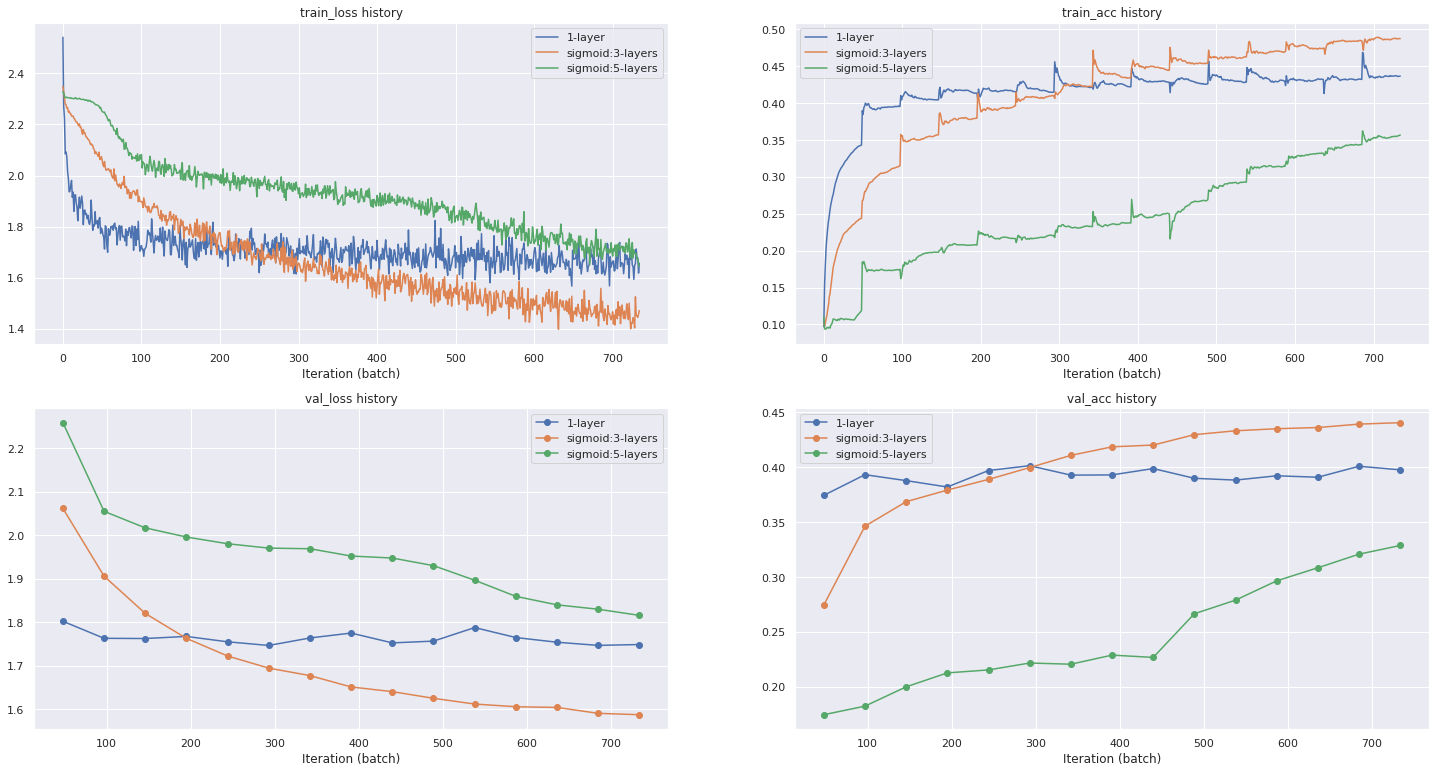

In [ ]:
plot_experiments(experiments.items())

### 7 слоев

In [ ]:
n_layers = 7
model = make_mlp(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, out_dim=N_CLASSES, n_layers=n_layers, activation=nn.Sigmoid)
print(summary(model, input_size=(INPUT_DIM,), device='cpu'))
optimizer = torch.optim.Adam(model.parameters())
experiments[f'sigmoid:{n_layers}-layers'] = train(model, train_loader, test_loader, criterion, optimizer, epochs=EPOCHS, device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 3072]               0
            Linear-2                   [-1, 64]         196,672
           Sigmoid-3                   [-1, 64]               0
            Linear-4                   [-1, 64]           4,160
           Sigmoid-5                   [-1, 64]               0
            Linear-6                   [-1, 64]           4,160
           Sigmoid-7                   [-1, 64]               0
            Linear-8                   [-1, 64]           4,160
           Sigmoid-9                   [-1, 64]               0
           Linear-10                   [-1, 64]           4,160
          Sigmoid-11                   [-1, 64]               0
           Linear-12                   [-1, 64]           4,160
          Sigmoid-13                   [-1, 64]               0
           Linear-14                   

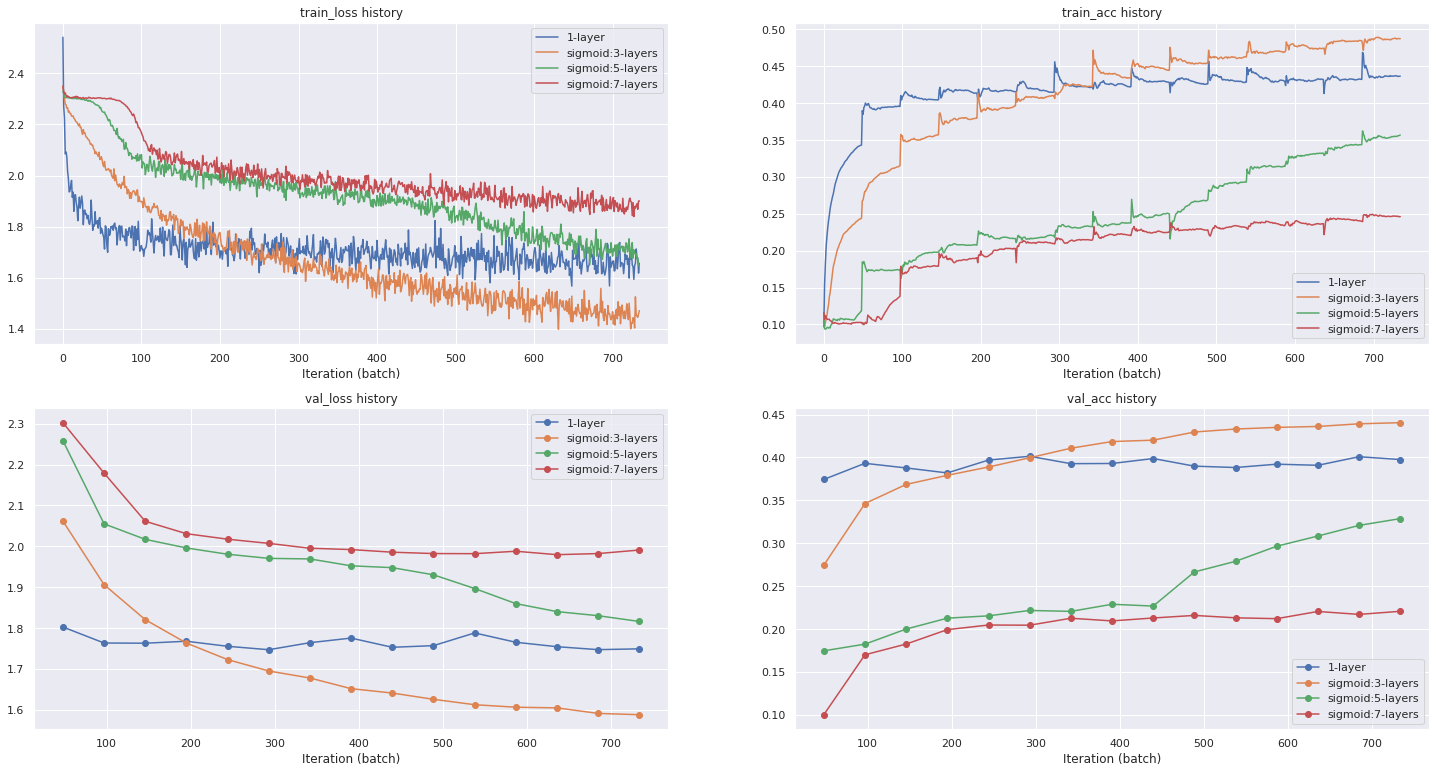

In [ ]:
plot_experiments(experiments.items())

### 10 слоев

In [ ]:
n_layers = 10
model = make_mlp(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, out_dim=N_CLASSES, n_layers=n_layers, activation=nn.Sigmoid)
print(summary(model, input_size=(INPUT_DIM,), device='cpu'))
optimizer = torch.optim.Adam(model.parameters())
experiments[f'sigmoid:{n_layers}-layers'] = train(model, train_loader, test_loader, criterion, optimizer, epochs=EPOCHS, device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 3072]               0
            Linear-2                   [-1, 64]         196,672
           Sigmoid-3                   [-1, 64]               0
            Linear-4                   [-1, 64]           4,160
           Sigmoid-5                   [-1, 64]               0
            Linear-6                   [-1, 64]           4,160
           Sigmoid-7                   [-1, 64]               0
            Linear-8                   [-1, 64]           4,160
           Sigmoid-9                   [-1, 64]               0
           Linear-10                   [-1, 64]           4,160
          Sigmoid-11                   [-1, 64]               0
           Linear-12                   [-1, 64]           4,160
          Sigmoid-13                   [-1, 64]               0
           Linear-14                   

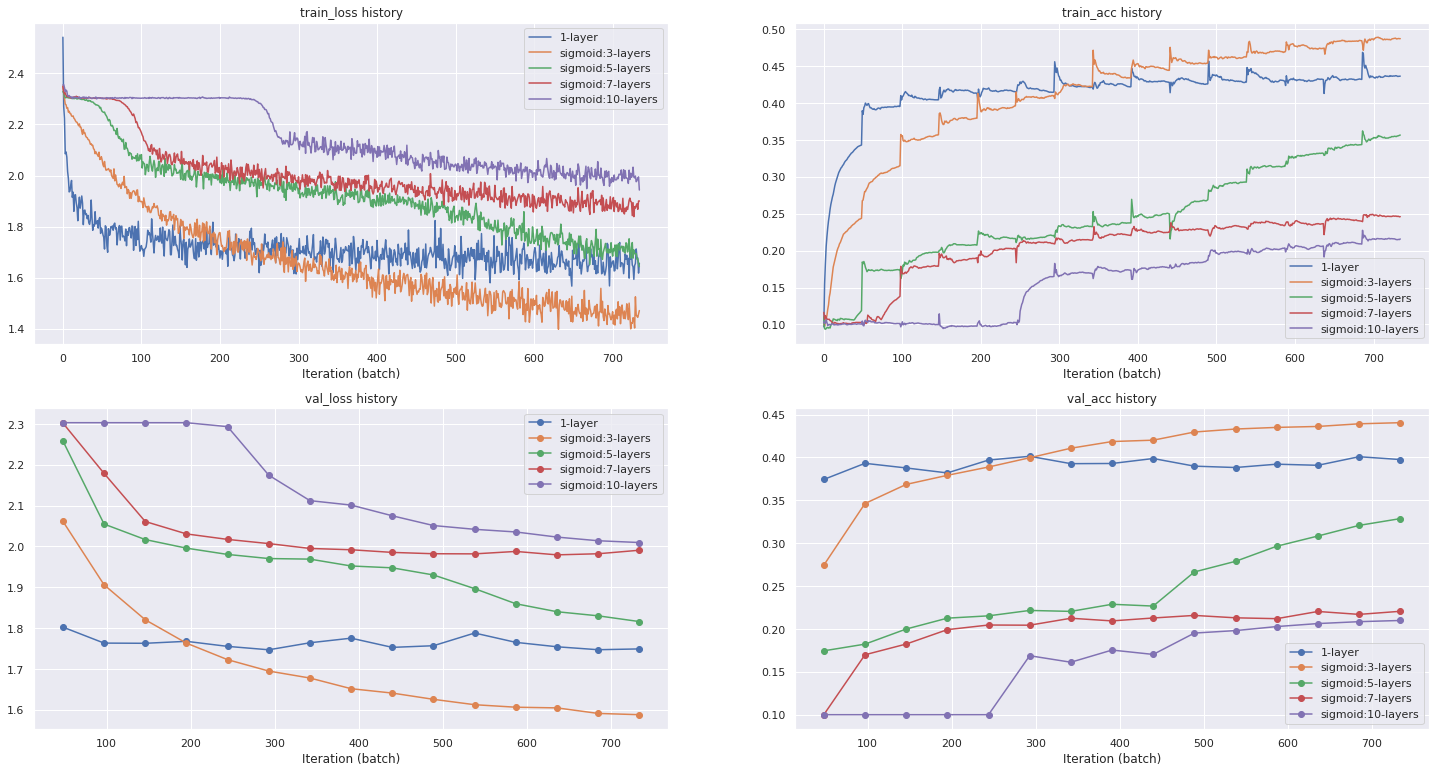

In [ ]:
plot_experiments(experiments.items())

## Tanh

### 7 слоев

In [ ]:
n_layers = 7
model = make_mlp(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, out_dim=N_CLASSES, n_layers=n_layers, activation=nn.Tanh)
print(summary(model, input_size=(INPUT_DIM,), device='cpu'))
optimizer = torch.optim.Adam(model.parameters())
experiments[f'tanh:{n_layers}-layers'] = train(model, train_loader, test_loader, criterion, optimizer, epochs=EPOCHS, device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 3072]               0
            Linear-2                   [-1, 64]         196,672
              Tanh-3                   [-1, 64]               0
            Linear-4                   [-1, 64]           4,160
              Tanh-5                   [-1, 64]               0
            Linear-6                   [-1, 64]           4,160
              Tanh-7                   [-1, 64]               0
            Linear-8                   [-1, 64]           4,160
              Tanh-9                   [-1, 64]               0
           Linear-10                   [-1, 64]           4,160
             Tanh-11                   [-1, 64]               0
           Linear-12                   [-1, 64]           4,160
             Tanh-13                   [-1, 64]               0
           Linear-14                   

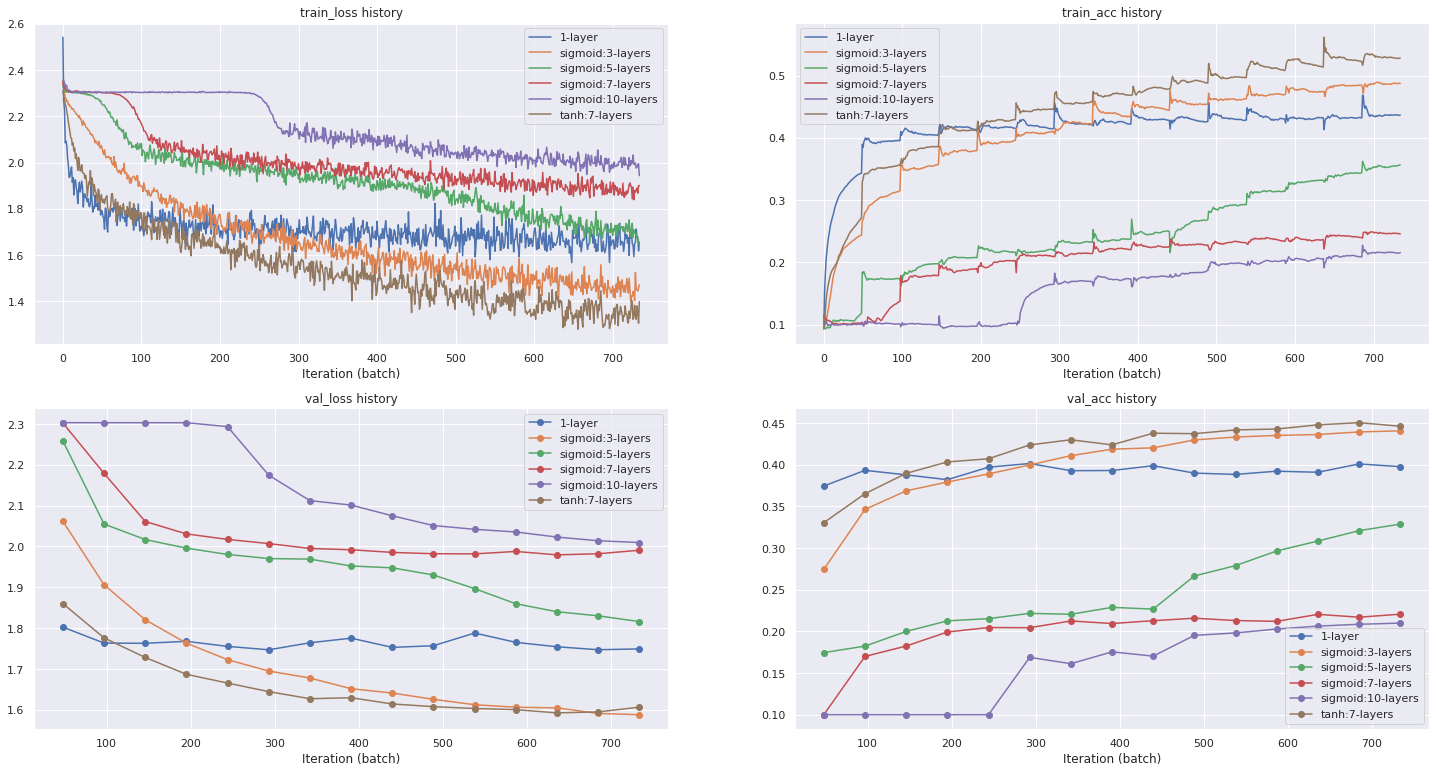

In [ ]:
plot_experiments(experiments.items())

### 10 слоев

In [ ]:
n_layers = 10
model = make_mlp(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, out_dim=N_CLASSES, n_layers=n_layers, activation=nn.Tanh)
print(summary(model, input_size=(INPUT_DIM,), device='cpu'))
optimizer = torch.optim.Adam(model.parameters())
experiments[f'tanh:{n_layers}-layers'] = train(model, train_loader, test_loader, criterion, optimizer, epochs=EPOCHS, device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 3072]               0
            Linear-2                   [-1, 64]         196,672
              Tanh-3                   [-1, 64]               0
            Linear-4                   [-1, 64]           4,160
              Tanh-5                   [-1, 64]               0
            Linear-6                   [-1, 64]           4,160
              Tanh-7                   [-1, 64]               0
            Linear-8                   [-1, 64]           4,160
              Tanh-9                   [-1, 64]               0
           Linear-10                   [-1, 64]           4,160
             Tanh-11                   [-1, 64]               0
           Linear-12                   [-1, 64]           4,160
             Tanh-13                   [-1, 64]               0
           Linear-14                   

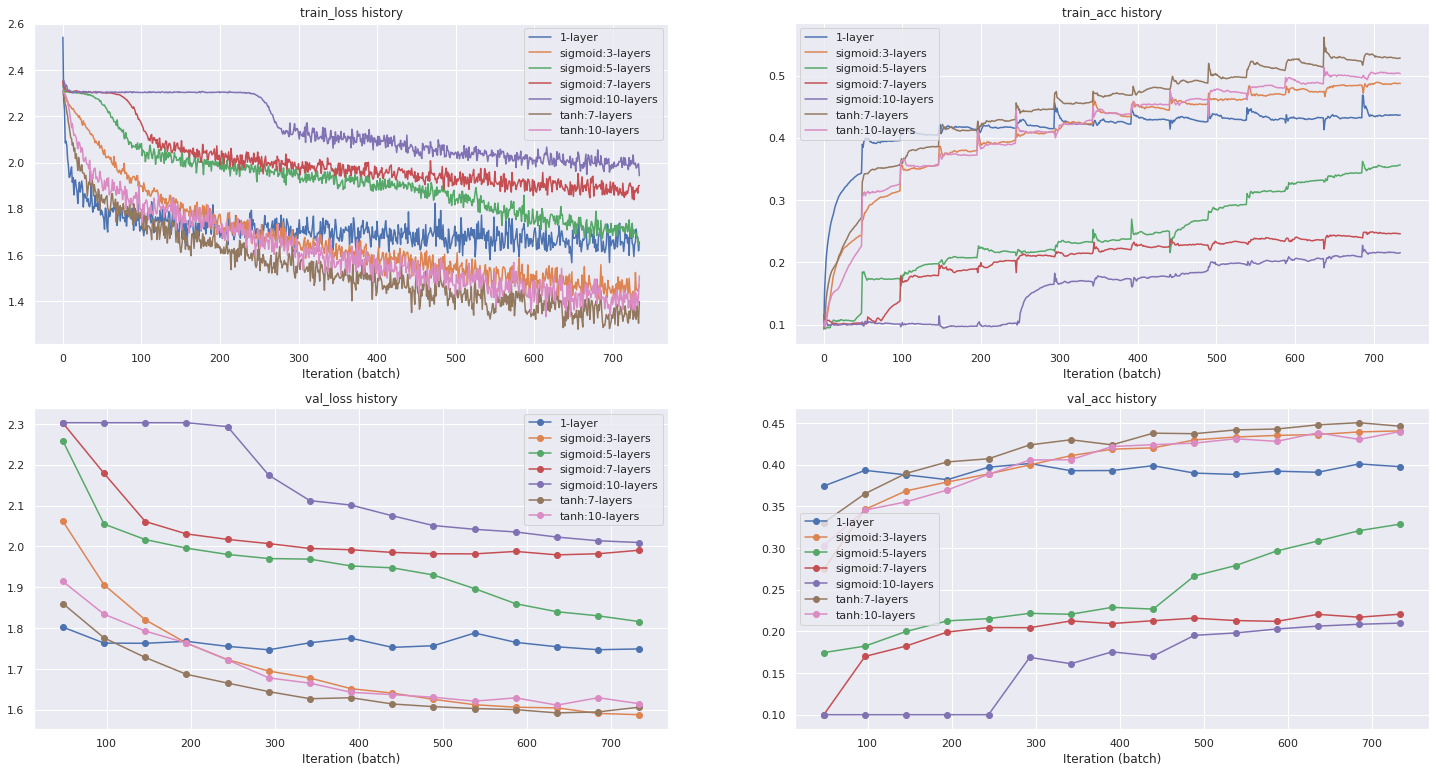

In [ ]:
plot_experiments(experiments.items())

## ReLU

### 7 слоев

In [ ]:
n_layers = 7
model = make_mlp(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, out_dim=N_CLASSES, n_layers=n_layers, activation=nn.ReLU)
print(summary(model, input_size=(INPUT_DIM,), device='cpu'))
optimizer = torch.optim.Adam(model.parameters())
experiments[f'relu:{n_layers}-layers'] = train(model, train_loader, test_loader, criterion, optimizer, epochs=EPOCHS, device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 3072]               0
            Linear-2                   [-1, 64]         196,672
              ReLU-3                   [-1, 64]               0
            Linear-4                   [-1, 64]           4,160
              ReLU-5                   [-1, 64]               0
            Linear-6                   [-1, 64]           4,160
              ReLU-7                   [-1, 64]               0
            Linear-8                   [-1, 64]           4,160
              ReLU-9                   [-1, 64]               0
           Linear-10                   [-1, 64]           4,160
             ReLU-11                   [-1, 64]               0
           Linear-12                   [-1, 64]           4,160
             ReLU-13                   [-1, 64]               0
           Linear-14                   

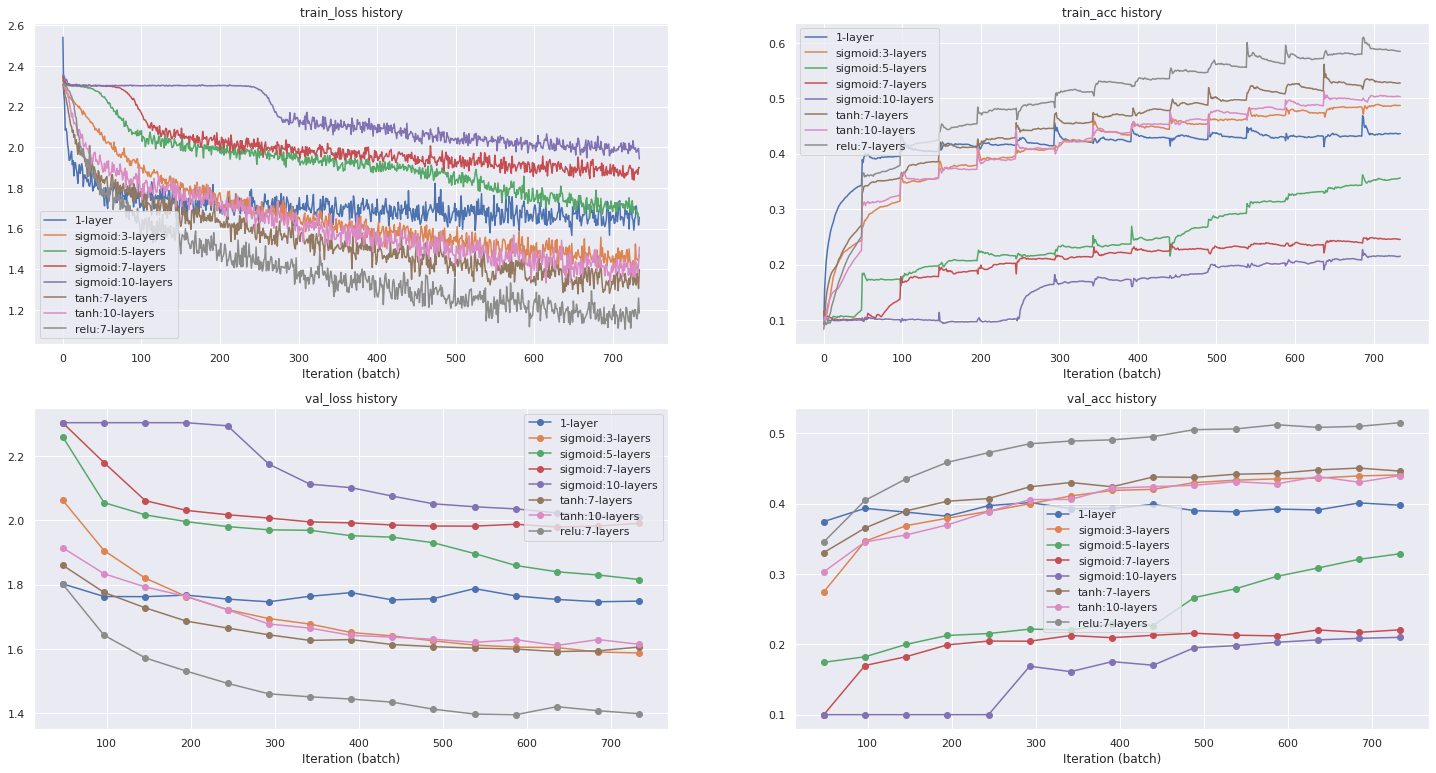

In [ ]:
plot_experiments(experiments.items())

### 10 слоев

In [ ]:
n_layers = 10
model = make_mlp(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, out_dim=N_CLASSES, n_layers=n_layers, activation=nn.ReLU)
print(summary(model, input_size=(INPUT_DIM,), device='cpu'))
optimizer = torch.optim.Adam(model.parameters())
experiments[f'relu:{n_layers}-layers'] = train(model, train_loader, test_loader, criterion, optimizer, epochs=EPOCHS, device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 3072]               0
            Linear-2                   [-1, 64]         196,672
              ReLU-3                   [-1, 64]               0
            Linear-4                   [-1, 64]           4,160
              ReLU-5                   [-1, 64]               0
            Linear-6                   [-1, 64]           4,160
              ReLU-7                   [-1, 64]               0
            Linear-8                   [-1, 64]           4,160
              ReLU-9                   [-1, 64]               0
           Linear-10                   [-1, 64]           4,160
             ReLU-11                   [-1, 64]               0
           Linear-12                   [-1, 64]           4,160
             ReLU-13                   [-1, 64]               0
           Linear-14                   

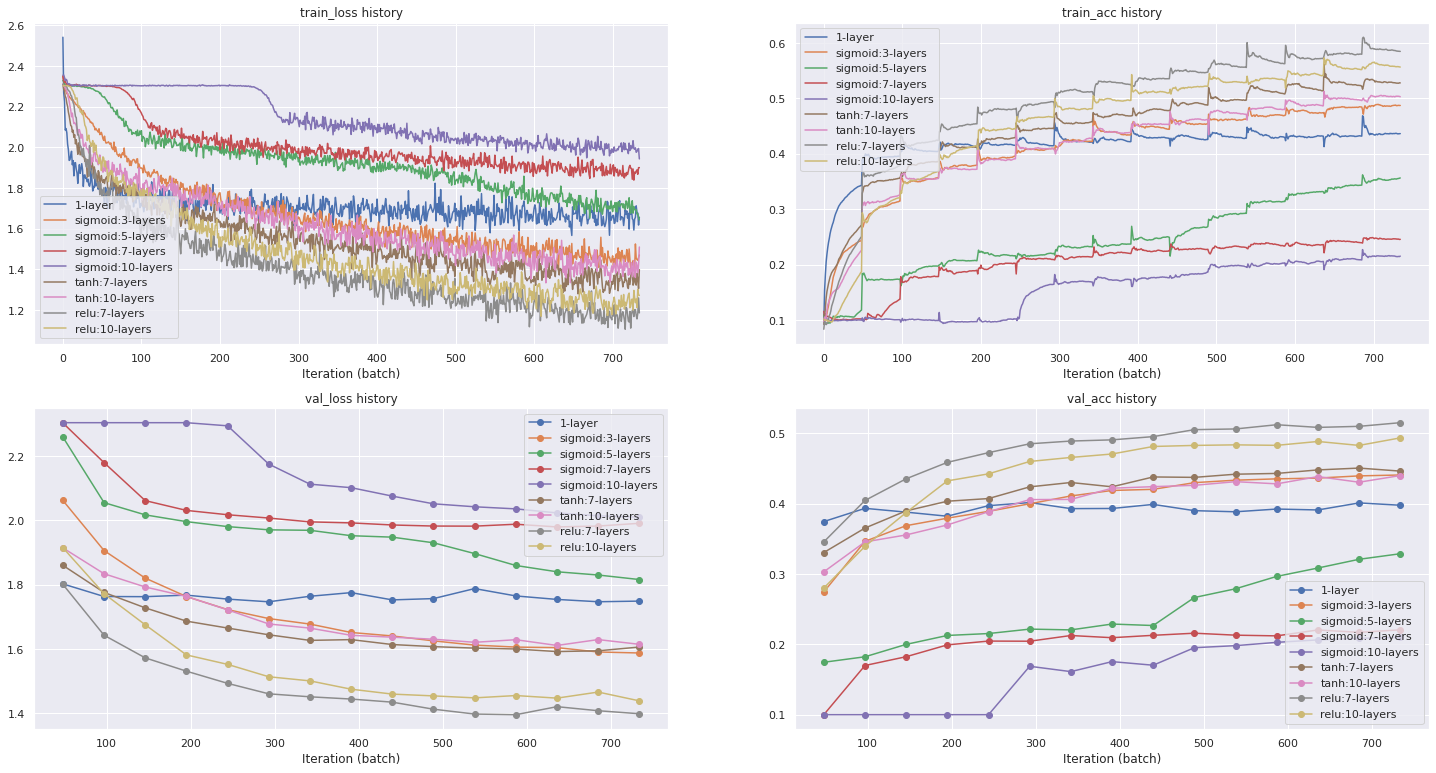

In [ ]:
plot_experiments(experiments.items())

# CNN

In [ ]:
# выкинем часть экспериментов, чтобы не загромождать график
experiments.pop('sigmoid:7-layers')
experiments.pop('sigmoid:10-layers')
experiments.pop('tanh:10-layers')
experiments.pop('relu:10-layers')

train_loss  train_acc  val_loss  val_acc
0      2.302349   0.102539       NaN      NaN
1      2.304324   0.100098       NaN      NaN
2      2.302983   0.100260       NaN      NaN
3      2.302764   0.100342       NaN      NaN
4      2.302602   0.100781       NaN      NaN
..          ...        ...       ...      ...
730    1.254554   0.557292       NaN      NaN
731    1.212438   0.557405       NaN      NaN
732    1.302662   0.557160       NaN      NaN
733    1.276338   0.556925       NaN      NaN
734    1.272348   0.556580  1.439169   0.4933

[735 rows x 4 columns]

In [ ]:
# зафиксированные параметры обучения
IN_CHANNELS = 3
OUT_DIM = 10
BATCH_SIZE = 1024
EPOCHS = 20

### Однослойная CNN

In [ ]:
model = nn.Sequential(
    nn.Conv2d(in_channels=IN_CHANNELS, out_channels=OUT_DIM, kernel_size=5),
    nn.ReLU(inplace=True),
    nn.AdaptiveAvgPool2d(output_size=(1, 1)),
    nn.Flatten(),
)
print(summary(model, input_size=(3, 32, 32), device='cpu'))
optimizer = torch.optim.Adam(model.parameters())
experiments['cnn:1-layer'] = train(model, train_loader, test_loader, criterion, optimizer, epochs=EPOCHS, device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]             760
              ReLU-2           [-1, 10, 28, 28]               0
 AdaptiveAvgPool2d-3             [-1, 10, 1, 1]               0
           Flatten-4                   [-1, 10]               0
Total params: 760
Trainable params: 760
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.12
Params size (MB): 0.00
Estimated Total Size (MB): 0.13
----------------------------------------------------------------
None


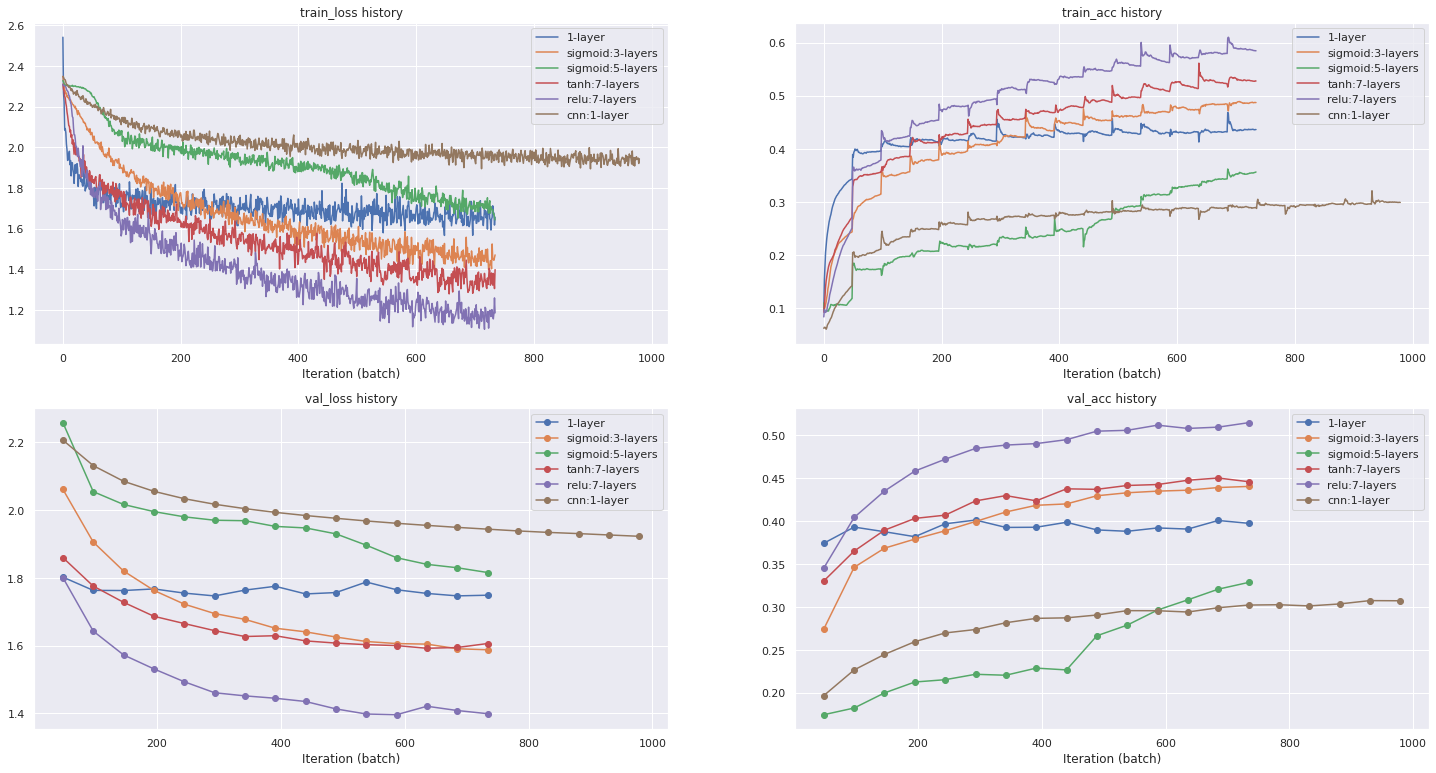

In [ ]:
plot_experiments(experiments.items())

### 3 слоя

In [ ]:
model = nn.Sequential(
    nn.Conv2d(in_channels=IN_CHANNELS, out_channels=64, kernel_size=5),
    nn.ReLU(inplace=True),
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
    nn.ReLU(inplace=True),
    nn.Conv2d(in_channels=128, out_channels=10, kernel_size=3),
    nn.ReLU(inplace=True),
    nn.AdaptiveAvgPool2d(output_size=(1, 1)),
    nn.Flatten(),
)
print(summary(model, input_size=(3, 32, 32), device='cpu'))
optimizer = torch.optim.Adam(model.parameters())
experiments['cnn:3-layers'] = train(model, train_loader, test_loader, criterion, optimizer, epochs=EPOCHS, device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]           4,864
              ReLU-2           [-1, 64, 28, 28]               0
            Conv2d-3          [-1, 128, 26, 26]          73,856
              ReLU-4          [-1, 128, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]          11,530
              ReLU-6           [-1, 10, 24, 24]               0
 AdaptiveAvgPool2d-7             [-1, 10, 1, 1]               0
           Flatten-8                   [-1, 10]               0
Total params: 90,250
Trainable params: 90,250
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 2.17
Params size (MB): 0.34
Estimated Total Size (MB): 2.53
----------------------------------------------------------------
None


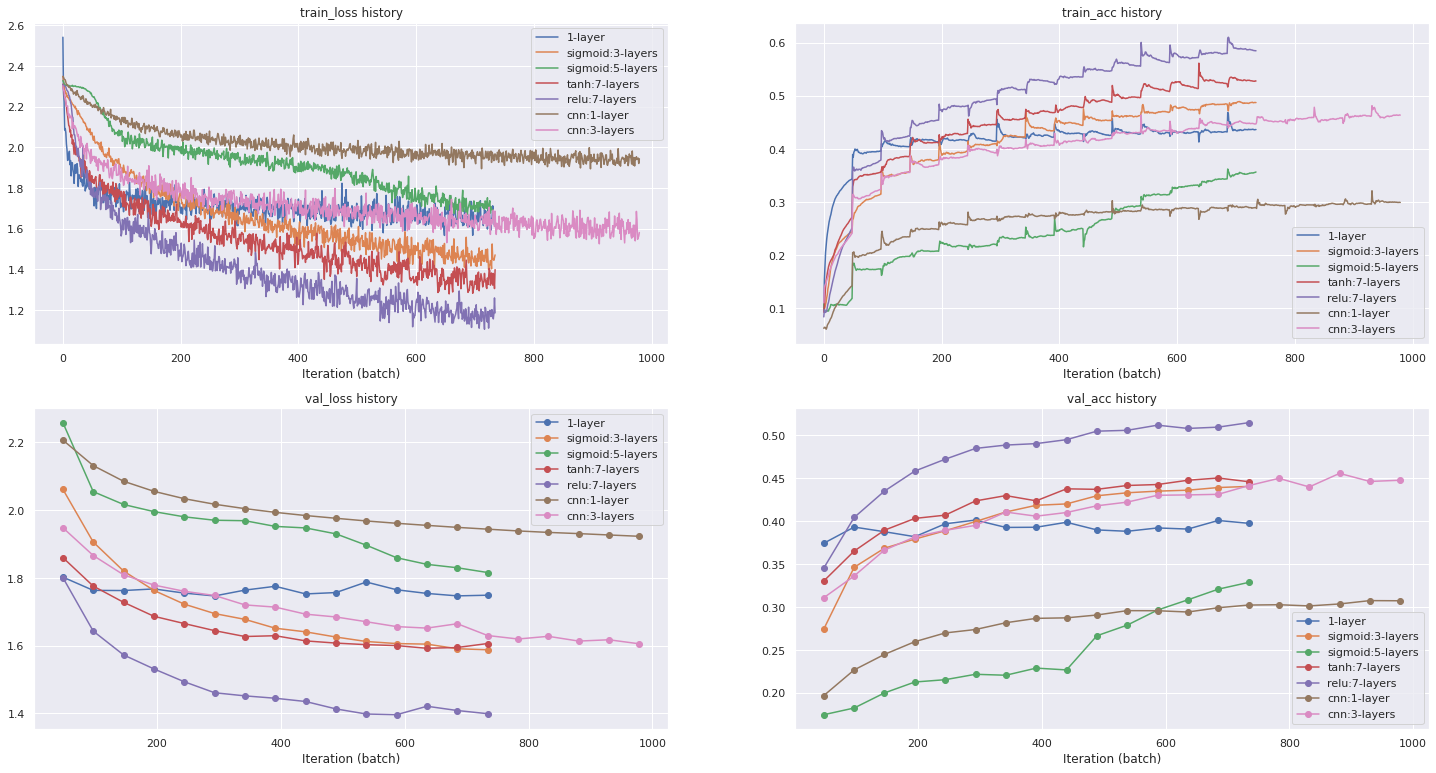

In [ ]:
plot_experiments(experiments.items())

### Standard simple CNN architecture

In [ ]:
model = nn.Sequential(
    nn.Conv2d(in_channels=IN_CHANNELS, out_channels=16, kernel_size=3),
    nn.ReLU(inplace=True),
    nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
    nn.ReLU(inplace=True),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(in_features=128, out_features=OUT_DIM),
)
print(summary(model, input_size=(3, 32, 32), device='cpu'))
optimizer = torch.optim.Adam(model.parameters())
history_layers['cnn:maxpool'] = train(model, train_loader, test_loader, criterion, optimizer, epochs=EPOCHS, device=device)

In [ ]:
plot_experiments(history_layers.items())

In [ ]:
model = nn.Sequential(
    nn.Conv2d(in_channels=IN_CHANNELS, out_channels=16, kernel_size=3),
    nn.ReLU(inplace=True),
    nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
    nn.ReLU(inplace=True),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(in_channels=64, out_channels=OUT_DIM, kernel_size=3),
    nn.ReLU(inplace=True),
    nn.AdaptiveAvgPool2d(output_size=(1, 1)),
    nn.Flatten(),
)
print(summary(model, input_size=(3, 32, 32), device='cpu'))
optimizer = torch.optim.Adam(model.parameters())
history_layers['fullconv'] = train(model, train_loader, test_loader, criterion, optimizer, epochs=EPOCHS, device=device)

In [ ]:
plot_experiments(history_layers.items())

In [ ]:
model = nn.Sequential(
    nn.Conv2d(in_channels=IN_CHANNELS, out_channels=64, kernel_size=3, padding=1, bias=False),
    nn.BatchNorm2d(num_features=64),
    nn.ReLU(inplace=True),
    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, bias=False),
    nn.BatchNorm2d(num_features=64),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, bias=False),
    nn.BatchNorm2d(num_features=128),
    nn.ReLU(inplace=True),
    nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, bias=False),
    nn.BatchNorm2d(num_features=128),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, bias=False),
    nn.BatchNorm2d(num_features=256),
    nn.ReLU(inplace=True),
    nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, bias=False),
    nn.BatchNorm2d(num_features=256),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, bias=False),
    nn.BatchNorm2d(num_features=512),
    nn.ReLU(inplace=True),
    nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, bias=False),
    nn.BatchNorm2d(num_features=512),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(in_channels=512, out_channels=OUT_DIM, kernel_size=1),
    nn.AdaptiveAvgPool2d(output_size=(1, 1)),
    nn.Flatten(),
)
print(summary(model, input_size=(3, 32, 32), device='cpu'))
optimizer = torch.optim.Adam(model.parameters())
experiments['fullconv_bn'] = train(model, train_loader, test_loader, criterion, optimizer, epochs=EPOCHS, device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,728
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
        MaxPool2d-14            [-1, 12

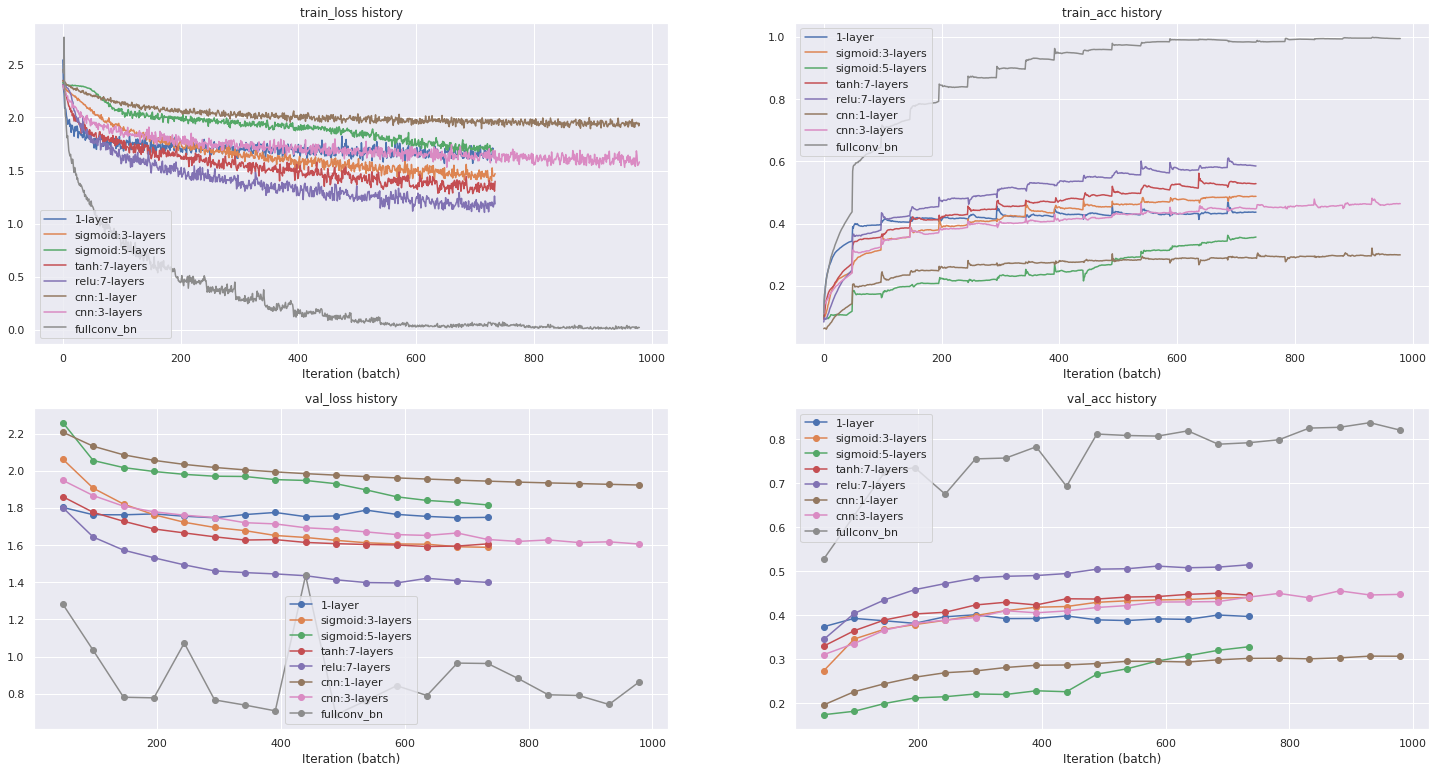

In [ ]:
plot_experiments(experiments.items())